In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import RFormula
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score
import math

In [0]:
file_path = "dbfs:/FileStore/framingham.csv"
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)
heart = pd.read_csv("/dbfs/FileStore/framingham.csv")
heart.dropna(axis=0, inplace=True)

Out[9]:

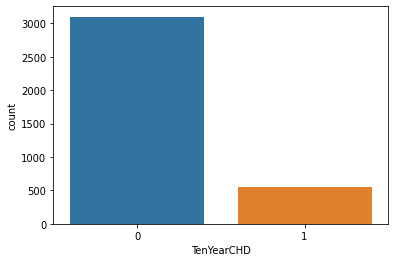

<AxesSubplot:xlabel='TenYearCHD', ylabel='count'>

In [0]:
#Data Exploration
sns.countplot(x="TenYearCHD", data=heart)

In [0]:
heart.corr()["TenYearCHD"]

Out[6]: male 0.088428
age 0.225256
education -0.054059
currentSmoker 0.019456
cigsPerDay 0.057884
BPMeds 0.087489
prevalentStroke 0.061810
prevalentHyp 0.177603
diabetes 0.097317
totChol 0.082184
sysBP 0.216429
diaBP 0.145299
BMI 0.075192
heartRate 0.022913
glucose 0.125544
TenYearCHD 1.000000
Name: TenYearCHD, dtype: float64

Correlation Coefficients are low.
Perform ChiSquare Test

In [0]:
#define x and y
X = heart.iloc[:, :(heart.shape[1]-1)]
Y = heart.iloc[:, -1]

In [0]:
chi_square, p_values = chi2(X, Y)
p_values_df = pd.DataFrame(p_values, columns=["p_val"], index = X.columns)
p_values_df["chi_square"] = chi_square
#p_values_df["pvalue_to3dp"] = round(p_values_df["p_val"], 3)

ind_bin = [0, 0.05, 1]
ind_label = ["Dependence (Reject H0:No dependence)", "Independence (Fail to Reject H0: No dependence)"]
p_values_df["conclusion"] = pd.cut(p_values_df["p_val"], bins= ind_bin, labels=ind_label)

p_values_df

Out[13]:

,p_val,chi_square,conclusion
male,3.508289e-05,17.120430,Dependence (Reject H0:No dependence)
age,3.136918e-66,295.507761,Dependence (Reject H0:No dependence)
education,5.584246e-03,7.679797,Dependence (Reject H0:No dependence)
currentSmoker,4.072163e-01,0.686913,Independence (Fail to Reject H0: No dependence)
cigsPerDay,6.363520e-36,156.567318,Dependence (Reject H0:No dependence)
BPMeds,1.120936e-07,28.153003,Dependence (Reject H0:No dependence)
prevalentStroke,3.555717e-03,8.497823,Dependence (Reject H0:No dependence)
prevalentHyp,8.342694e-20,82.967184,Dependence (Reject H0:No dependence)
diabetes,2.543345e-08,31.027987,Dependence (Reject H0:No dependence)
totChol,3.972625e-56,249.153078,Dependence (Reject H0:No dependence)


Feature Selection

In [0]:
inputCols = []

for i in range(len(p_values_df)):
  if p_values_df["p_val"][i] < 0.05:
    inputCols.append(p_values_df.index[i])

Predict TenYearCHD 
1. Using Logisic Regression (Spark ML)
2. Random Forest Classifier

In [0]:
df_spark.printSchema()

root
-- male: integer (nullable = true)
-- age: integer (nullable = true)
-- education: string (nullable = true)
-- currentSmoker: integer (nullable = true)
-- cigsPerDay: string (nullable = true)
-- BPMeds: string (nullable = true)
-- prevalentStroke: integer (nullable = true)
-- prevalentHyp: integer (nullable = true)
-- diabetes: integer (nullable = true)
-- totChol: string (nullable = true)
-- sysBP: double (nullable = true)
-- diaBP: double (nullable = true)
-- BMI: string (nullable = true)
-- heartRate: string (nullable = true)
-- glucose: string (nullable = true)
-- TenYearCHD: integer (nullable = true)

In [0]:
df_schema = (df_spark.withColumn("education", col("education").cast("int"))
              .withColumn("cigsPerDay", col("cigsPerDay").cast("int"))
              .withColumn("BPMeds", col("BPMeds").cast("int"))
              .withColumn("totChol", col("totChol").cast("double"))
              .withColumn("BMI", col("BMI").cast("double"))
              .withColumn("heartRate", col("heartRate").cast("double"))
              .withColumn("glucose", col("glucose").cast("double"))
             )

In [0]:
(trainDF, testDF) = df_schema.randomSplit([.7, .3], seed=42)

1. Logistic Regression Prediction

In [0]:
vecAssembler = VectorAssembler(inputCols=inputCols, outputCol="features", handleInvalid="skip")
lr = LogisticRegression(labelCol = "TenYearCHD", featuresCol = "features")

evaluator = BinaryClassificationEvaluator(labelCol = "TenYearCHD")

paramGrid = (ParamGridBuilder()
             .addGrid(lr.threshold, [0.5])
             .build()
            )

cv = CrossValidator(estimator=lr, evaluator=evaluator,estimatorParamMaps=paramGrid,
                    numFolds=2, parallelism=4, seed=42
                   )

pipeline_lr = Pipeline(stages=[vecAssembler, cv])
pipeline_logRegression = pipeline_lr.fit(trainDF)
pred_lr = pipeline_logRegression.transform(testDF)

2. Random Forest

In [0]:
intCols = [field for (field, dataType) in trainDF.dtypes if (field != "TenYearCHD")]
vecAssembler_rf = VectorAssembler(inputCols=intCols, outputCol="features", handleInvalid="skip")

rf = RandomForestClassifier(labelCol="TenYearCHD", maxBins=40, seed=42)

paramGrid_rf = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2,10])
             .addGrid(rf.numTrees, [5,15])
             .build()
            )
evaluator_rf = MulticlassClassificationEvaluator(labelCol="TenYearCHD", predictionCol="prediction", metricName="f1")

cv_rf = CrossValidator(estimator=rf, evaluator=evaluator_rf, estimatorParamMaps=paramGrid_rf, 
                    numFolds=3, parallelism=4, seed=42
                   )
pipeline_rf = Pipeline(stages= [vecAssembler_rf, cv_rf])
pipeline_rfclass = pipeline_rf.fit(trainDF)
pred_rf = pipeline_rfclass.transform(testDF)

Checking Accuracy Using F1_score from Sklearn.Metric

In [0]:
yhat_lr = pred_lr.select("prediction").toPandas()
yhat_rf = pred_rf.select("prediction").toPandas()
y_lr = pred_lr.select("TenYearCHD").toPandas()
y_rf = pred_rf.select("TenYearCHD").toPandas()

f1_score_check = [f1_score(y_lr, yhat_lr)*100, f1_score(y_rf, yhat_rf)*100]

fscore_df = pd.DataFrame(f1_score_check, columns=["f1_score"], index = ["logisticRegression", "RandomForestClassifier"]).transpose()

fscore_df

Out[53]:

,logisticRegression,RandomForestClassifier
f1_score,13.414634,22.099448


The Famingham Risk Score states that individuals with probability estimation greater than 20% have a high risk of Coronary Heart Disease
Adjust Approximation Threshold to 20%

In [0]:
#LogisticRegression_0.2
vecAssembler_two = VectorAssembler(inputCols=inputCols, outputCol="features", handleInvalid="skip")
lr_two = LogisticRegression(labelCol = "TenYearCHD", featuresCol = "features")

evaluator_two = BinaryClassificationEvaluator(labelCol = "TenYearCHD")

paramGrid_two = (ParamGridBuilder()
             .addGrid(lr_two.threshold, [0.2])
             .build()
            )

cv_two = CrossValidator(estimator=lr_two, evaluator=evaluator_two,estimatorParamMaps=paramGrid_two,
                    numFolds=3, parallelism=4,
                   )

pipeline_lr_two = Pipeline(stages=[vecAssembler_two, cv_two])
pipeline_logRegression_two = pipeline_lr_two.fit(trainDF)
pred_lr_two = pipeline_logRegression_two.transform(testDF)


In [0]:
yhat_lr_two = pred_lr_two.select("prediction").toPandas()
y_lr_two = pred_lr_two.select("TenYearCHD").toPandas()

f1_score_check_two = [f1_score(y_lr_two, yhat_lr_two)*100]

fscore_df_two = pd.DataFrame(f1_score_check_two, columns=["f1_score"], index = ["logisticRegression%"]).transpose()

fscore_df_two

Out[108]:

,logisticRegression%
f1_score,39.26097


Data Exploration

In [0]:
#group by age
group_by_currentSmoker = heart.groupby("currentSmoker").agg({"male":"count","age":"mean", "cigsPerDay":"mean", "BPMeds": "sum",
                                                              "prevalentStroke":"sum", "prevalentHyp":"sum", "diabetes":"sum",
                                                              "totChol":"mean", "BMI":"mean", "heartRate":"mean", "glucose":"mean",
                                                              "TenYearCHD":"sum"})
group_by_currentSmoker.transpose()

Out[70]:

currentSmoker,0,1
male,1868.000000,1788.000000
age,51.323340,47.712528
cigsPerDay,0.000000,18.447987
BPMeds,73.000000,38.000000
prevalentStroke,16.000000,5.000000
prevalentHyp,673.000000,466.000000
diabetes,63.000000,36.000000
totChol,239.078158,234.569351
BMI,26.418865,25.121107
heartRate,75.139186,76.348434


In [0]:
#group by gender
group_by_gender = heart.groupby(["currentSmoker", "male"]).agg({"age":"mean", "cigsPerDay":"mean", "BPMeds": "sum",
                                                              "prevalentStroke":"sum", "prevalentHyp":"sum", "diabetes":"sum",
                                                              "totChol":"mean", "BMI":"mean", "heartRate":"mean", "glucose":"mean",
                                                              "TenYearCHD":"sum"})
group_by_gender.transpose()

Out[71]:

currentSmoker 
 0 
 1 
 
 
 male 
 0 
 1 
 0 
 1 
 
 
 
 
 age 
 51.594947 
 50.803432 
 46.929368 
 48.356779 
 
 
 cigsPerDay 
 0.000000 
 0.000000 
 13.855019 
 22.226300 
 
 
 BPMeds 
 54.000000 
 19.000000 
 24.000000 
 14.000000 
 
 
 prevalentStroke 
 10.000000 
 6.000000 
 2.000000 
 3.000000 
 
 
 prevalentHyp 
 457.000000 
 216.000000 
 176.000000 
 290.000000 
 
 
 diabetes 
 34.000000 
 29.000000 
 17.000000 
 19.000000 
 
 
 totChol 
 243.171964 
 231.241810 
 234.265180 
 234.819572 
 
 
 BMI 
 26.213456 
 26.812059 
 24.464758 
 25.661040 
 
 
 heartRate 
 76.665852 
 72.216849 
 77.407683 
 75.477064 
 
 
 glucose 
 82.647107 
 83.978159 
 80.489467 
 80.604485 
 
 
 TenYearCHD 
 162.000000 
 110.000000 
 88.000000 
 197.000000

Visual Check for Age as a confounder

In [0]:
age_grp_bin = [ 0,math.trunc(heart["age"].mean()), 100]
age_class = ["< 50", ">=50"]

heart["age_grp"] = pd.cut(heart["age"], bins= age_grp_bin, labels=age_class)

In [0]:
group_by_ageClass = heart.groupby("age_grp").agg({"TenYearCHD": "sum"})
group_by_ageClass

Out[75]:

,TenYearCHD
age_grp,
< 50,159
>=50,398


In [0]:
group_by_ageSmoker = heart.groupby("age_grp").agg({"currentSmoker": "sum"})
group_by_ageSmoker

Out[76]:

,currentSmoker
age_grp,
< 50,1119
>=50,669


Out[77]:

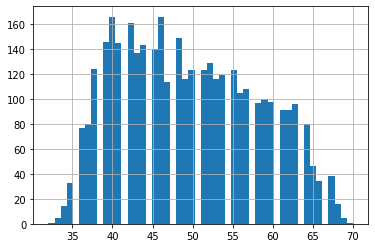

<AxesSubplot:>

In [0]:
heart["age"].hist(bins=50)

Check Confounding Using Measure of Association

In [0]:
#Grouping the Data
a = len(heart[(heart["currentSmoker"]==1)&(heart["TenYearCHD"]==1)])
b = len(heart[(heart["currentSmoker"]==1) & (heart["TenYearCHD"]==0)])
c = len(heart[(heart["currentSmoker"]==0) & (heart["TenYearCHD"] == 1)])
d = len(heart[(heart["currentSmoker"]==0) & (heart["TenYearCHD"] == 0)])

tot_r1 = a+b
tot_r2 = c+d
tot_c1 = a+c
tot_c2 = b+d
tot_c3 = tot_r1 + tot_r2

unadjusted_analysis = pd.DataFrame([[a, b, tot_r1], [c, d, tot_r2], [tot_c1, tot_c2, tot_c3]], 
                              columns = ["TenYearCHD", "NoTenYearCHD", "total"], 
                              index = ["Smoker", "NonSmoker", "Total"])
unadjusted_analysis 

Out[80]:

,TenYearCHD,NoTenYearCHD,total
Smoker,285,1503,1788
NonSmoker,272,1596,1868
Total,557,3099,3656


In [0]:
crude_RiskRatio = (unadjusted_analysis["TenYearCHD"]["Smoker"]/ unadjusted_analysis["total"]["Smoker"]) / (unadjusted_analysis["TenYearCHD"]["NonSmoker"]/ unadjusted_analysis["total"]["NonSmoker"])
crude_RiskRatio

Out[82]: 1.0946752862218714

stratify by age

In [0]:
heart_young = heart[heart["age"] < 50]
heart_old = heart[heart["age"] >= 50]

a_y = len(heart_young[(heart_young["currentSmoker"]==1)&(heart_young["TenYearCHD"]==1)])
b_y = len(heart_young[(heart_young["currentSmoker"]==1) & (heart_young["TenYearCHD"]==0)])
c_y = len(heart_young[(heart_young["currentSmoker"]==0) & (heart_young["TenYearCHD"] == 1)])
d_y = len(heart_young[(heart_young["currentSmoker"]==0) & (heart_young["TenYearCHD"] == 0)])

tot_r1_y = a_y + b_y
tot_r2_y = c_y + d_y
tot_c1_y = a_y + c_y
tot_c2_y = b_y + d_y
tot_c3_y = tot_r1_y + tot_r2_y

strat_young = pd.DataFrame([[a_y, b_y, tot_r1_y], [c_y, d_y, tot_r2_y], [tot_c1_y, tot_c2_y, tot_c3_y]], 
                              columns = ["TenYearCHD_Young", "NoTenYearCHD_Young", "total_Young"], 
                              index = ["Smoker", "NonSmoker", "Total"])
strat_young

Out[83]:

,TenYearCHD_Young,NoTenYearCHD_Young,total_Young
Smoker,113,1006,1119
NonSmoker,46,752,798
Total,159,1758,1917


In [0]:
RiskRatio_young = (strat_young["TenYearCHD_Young"]["Smoker"]/ strat_young["total_Young"]["Smoker"]) / (strat_young["TenYearCHD_Young"]["NonSmoker"]/ strat_young["total_Young"]["NonSmoker"])
RiskRatio_young

Out[84]: 1.7518358783074952

In [0]:
a_o = len(heart_old[(heart_old["currentSmoker"]==1)&(heart_old["TenYearCHD"]==1)])
b_o = len(heart_old[(heart_old["currentSmoker"]==1) & (heart_old["TenYearCHD"]==0)])
c_o = len(heart_old[(heart_old["currentSmoker"]==0) & (heart_old["TenYearCHD"] == 1)])
d_o = len(heart_old[(heart_old["currentSmoker"]==0) & (heart_old["TenYearCHD"] == 0)])

tot_r1_o = a_o + b_o
tot_r2_o = c_o + d_o
tot_c1_o = a_o + c_o
tot_c2_o = b_o + d_o
tot_c3_o = tot_r1_o + tot_r2_o

strat_old = pd.DataFrame([[a_o, b_o, tot_r1_o], [c_o, d_o, tot_r2_o], [tot_c1_o, tot_c2_o, tot_c3_o]], 
                              columns = ["TenYearCHD_Old", "NoTenYearCHD_Old", "total_Old"], 
                              index = ["Smoker", "NonSmoker", "Total"])
strat_old

Out[85]:

,TenYearCHD_Old,NoTenYearCHD_Old,total_Old
Smoker,172,497,669
NonSmoker,226,844,1070
Total,398,1341,1739


In [0]:
RiskRatio_old = (strat_old["TenYearCHD_Old"]["Smoker"]/ strat_old["total_Old"]["Smoker"]) / (strat_old["TenYearCHD_Old"]["NonSmoker"]/ strat_old["total_Old"]["NonSmoker"])
RiskRatio_old

Out[86]: 1.2172440705318992

In [0]:
#Adjusted Risk Ratio
RRnum1 = (strat_young["TenYearCHD_Young"]["Smoker"] *(strat_young["TenYearCHD_Young"]["NonSmoker"]+ strat_young["NoTenYearCHD_Young"]["NonSmoker"]))/(strat_young["total_Young"]["Total"])
RRnum2 = (strat_old["TenYearCHD_Old"]["Smoker"] *(strat_old["TenYearCHD_Old"]["NonSmoker"]+ strat_old["NoTenYearCHD_Old"]["NonSmoker"]))/(strat_old["total_Old"]["Total"])
RRdenom1 = (strat_young["TenYearCHD_Young"]["NonSmoker"] *(strat_young["TenYearCHD_Young"]["Smoker"] + strat_young["NoTenYearCHD_Young"]["Smoker"]))/(strat_young["total_Young"]["Total"])
RRdenom2 = (strat_old["TenYearCHD_Old"]["NonSmoker"] *(strat_old["TenYearCHD_Old"]["Smoker"] + strat_old["NoTenYearCHD_Old"]["Smoker"]))/(strat_old["total_Old"]["Total"])

RR_adjusted = (RRnum1+RRnum2)/(RRdenom1+RRdenom2)
RR_adjusted

Out[87]: 1.3433882484251098

In [0]:
mag_of_effect = ((crude_RiskRatio - RR_adjusted)/RR_adjusted)*100
mag_of_effect

Out[88]: -18.513855729705195

Visual check for Gender as a confounding variable

In [0]:
gen_tenchd = heart.groupby("male").agg({"TenYearCHD": "sum"})
gen_tenchd

Out[89]:

,TenYearCHD
male,
0,250
1,307


In [0]:
group_by_genderSmoker = heart.groupby("male").agg({"currentSmoker": "sum"})
group_by_genderSmoker

Out[90]:

,currentSmoker
male,
0,807
1,981


Out[91]:

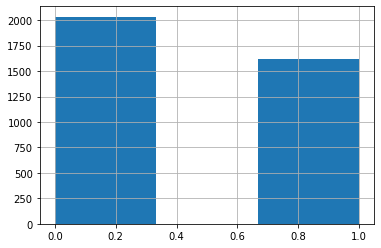

<AxesSubplot:>

In [0]:
heart["male"].hist(bins=3)

Check Confounding using Gender as Measure of Association

In [0]:
heart_male = heart[heart["male"] == 1]
heart_female = heart[heart["male"] == 0]

Male Strata

In [0]:
a_m = len(heart_male[(heart_male["currentSmoker"]==1)&(heart_male["TenYearCHD"]==1)])
b_m = len(heart_male[(heart_male["currentSmoker"]==1) & (heart_male["TenYearCHD"]==0)])
c_m = len(heart_male[(heart_male["currentSmoker"]==0) & (heart_male["TenYearCHD"] == 1)])
d_m = len(heart_male[(heart_male["currentSmoker"]==0) & (heart_male["TenYearCHD"] == 0)])

tot_r1_m = a_m + b_m
tot_r2_m = c_m + d_m
tot_c1_m = a_m + c_m
tot_c2_m = b_m + d_m
tot_c3_m = tot_r1_m + tot_r2_m

strat_male = pd.DataFrame([[a_m, b_m, tot_r1_m], [c_m, d_m, tot_r2_m], [tot_c1_m, tot_c2_m, tot_c3_m]], 
                              columns = ["TenYearCHD_Male", "NoTenYearCHD_Male", "total_Male"], 
                              index = ["Smoker", "NonSmoker", "Total"])
strat_male

Out[93]:

,TenYearCHD_Male,NoTenYearCHD_Male,total_Male
Smoker,197,784,981
NonSmoker,110,531,641
Total,307,1315,1622


In [0]:
RiskRatio_male = (strat_male["TenYearCHD_Male"]["Smoker"]/ strat_male["total_Male"]["Smoker"]) / (strat_male["TenYearCHD_Male"]["NonSmoker"]/ strat_male["total_Male"]["NonSmoker"])
RiskRatio_male

Out[94]: 1.1702066536928923

In [0]:
a_f = len(heart_female[(heart_female["currentSmoker"]==1)&(heart_female["TenYearCHD"]==1)])
b_f = len(heart_female[(heart_female["currentSmoker"]==1) & (heart_female["TenYearCHD"]==0)])
c_f = len(heart_female[(heart_female["currentSmoker"]==0) & (heart_female["TenYearCHD"] == 1)])
d_f = len(heart_female[(heart_female["currentSmoker"]==0) & (heart_female["TenYearCHD"] == 0)])

tot_r1_f = a_f + b_f
tot_r2_f = c_f + d_f
tot_c1_f = a_f + c_f
tot_c2_f = b_f + d_f
tot_c3_f = tot_r1_f + tot_r2_f

strat_female = pd.DataFrame([[a_f, b_f, tot_r1_f], [c_f, d_f, tot_r2_f], [tot_c1_f, tot_c2_f, tot_c3_f]], 
                              columns = ["TenYearCHD_Female", "NoTenYearCHD_Female", "total_Female"], 
                              index = ["Smoker", "NonSmoker", "Total"])
strat_female

Out[95]:

,TenYearCHD_Female,NoTenYearCHD_Female,total_Female
Smoker,88,719,807
NonSmoker,162,1065,1227
Total,250,1784,2034


In [0]:
RiskRatio_female = (strat_female["TenYearCHD_Female"]["Smoker"]/ strat_female["total_Female"]["Smoker"]) / (strat_female["TenYearCHD_Female"]["NonSmoker"]/ strat_female["total_Female"]["NonSmoker"])
RiskRatio_female

Out[96]: 0.8259213364541741

In [0]:
RRnum1_g = (strat_male["TenYearCHD_Male"]["Smoker"] *(strat_male["TenYearCHD_Male"]["NonSmoker"]+ strat_male["NoTenYearCHD_Male"]["NonSmoker"]))/(strat_male["total_Male"]["Total"])
RRnum2_g = (strat_female["TenYearCHD_Female"]["Smoker"] *(strat_female["TenYearCHD_Female"]["NonSmoker"]+ strat_female["NoTenYearCHD_Female"]["NonSmoker"]))/(strat_female["total_Female"]["Total"])
RRdenom1_g = (strat_male["TenYearCHD_Male"]["NonSmoker"] *(strat_male["TenYearCHD_Male"]["Smoker"] + strat_male["NoTenYearCHD_Male"]["Smoker"]))/(strat_male["total_Male"]["Total"])
RRdenom2_g = (strat_female["TenYearCHD_Female"]["NonSmoker"] *(strat_female["TenYearCHD_Female"]["Smoker"] + strat_female["NoTenYearCHD_Female"]["Smoker"]))/(strat_female["total_Female"]["Total"])

RR_adjusted_g = (RRnum1_g+RRnum2_g)/(RRdenom1_g+RRdenom2_g)
RR_adjusted_g

Out[97]: 1.0010311964776675

In [0]:
mag_of_effect_g = ((crude_RiskRatio - RR_adjusted_g)/RR_adjusted_g)*100
mag_of_effect_g

Out[98]: 9.354762376408422

Conclusion
* The variables, Age and Gender are both Confounding Variables that cause bias in the estimation of the relationship between exposure variables and TenYearCHD